Importing packages and setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import copy
import random
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Loading in CIFAR-10 dataset and introducing noise


In [2]:
# Define transformations for CIFAR-10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Dataset with noisy labels
class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_rate, noise_type='symmetric'):
        self.dataset = dataset
        self.noise_rate = noise_rate
        self.noise_type = noise_type
        self.num_classes = 10
        self.noisy_labels = self._generate_noisy_labels()

    def _generate_noisy_labels(self):
        noisy_labels = copy.deepcopy(self.dataset.targets)
        num_samples = len(self.dataset)
        indices = list(range(num_samples))
        random.shuffle(indices)
        num_noise = int(self.noise_rate * num_samples)

        if self.noise_type == 'symmetric':
            # Apply symmetric noise: flip labels to any of the other classes with equal probability
            for i in indices[:num_noise]:
                noisy_labels[i] = random.randint(0, self.num_classes - 1)
                while noisy_labels[i] == self.dataset.targets[i]:
                    noisy_labels[i] = random.randint(0, self.num_classes - 1)

        elif self.noise_type == 'asymmetric':
            # Asymmetric noise: flip labels to specific class only
            # For CIFAR-10, we will use the following flips:
            # airplane → bird, automobile → truck, bird → airplane,
            # cat → dog, deer → horse, dog → cat, frog → bird,
            # horse → deer, ship → automobile, truck → automobile
            noise_mapping = {0: 2, 1: 9, 2: 0, 3: 5, 4: 7, 5: 3, 6: 2, 7: 4, 8: 1, 9: 1}

            for i in indices[:num_noise]:
                noisy_labels[i] = noise_mapping[self.dataset.targets[i]]

        print(f"Applied {self.noise_type} noise with rate {self.noise_rate}, {num_noise} labels corrupted")
        return noisy_labels

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        return img, self.noisy_labels[index]

    def __len__(self):
        return len(self.dataset)

100%|██████████| 170M/170M [00:02<00:00, 82.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Implementing loss functions

In [3]:
# Standard Cross-Entropy Loss
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, pred, true):
        return self.criterion(pred, true)

# Normalized Cross-Entropy Loss (NCE)
class NormalizedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(NormalizedCrossEntropyLoss, self).__init__()

    def forward(self, pred, true):
        # Convert labels to one-hot encoding
        num_classes = pred.size(1)
        true_one_hot = torch.zeros_like(pred).scatter_(1, true.unsqueeze(1), 1)

        # Normalized Cross-Entropy Loss
        pred_softmax = torch.softmax(pred, dim=1)
        pred_softmax = torch.clamp(pred_softmax, min=1e-7, max=1.0)

        # Calculate the NCE
        loss = -torch.sum(true_one_hot * torch.log(pred_softmax), dim=1)
        # Normalize to [0, 1]
        loss = loss / (-torch.log(torch.tensor(1.0/num_classes, device=pred.device)))

        return loss.mean()

# Focal Loss
class FocalLoss(nn.Module):
      def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

      def forward(self, pred, true):
        # Convert labels to one-hot encoding
        num_classes = pred.size(1)
        true_one_hot = torch.zeros_like(pred).scatter_(1, true.unsqueeze(1), 1)

        # Focal Loss calculation
        pred_softmax = torch.softmax(pred, dim=1)
        pred_softmax = torch.clamp(pred_softmax, min=1e-7, max=1.0)

        # Standard cross-entropy part
        ce_loss = -torch.sum(true_one_hot * torch.log(pred_softmax), dim=1)

        # Add focal weighting
        pt = torch.sum(true_one_hot * pred_softmax, dim=1)
        focal_weight = (1 - pt) ** self.gamma

        return (focal_weight * ce_loss).mean()

# Normalized Focal Loss (NFL)
class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, pred, true):
        # Convert labels to one-hot encoding
        num_classes = pred.size(1)
        true_one_hot = torch.zeros_like(pred).scatter_(1, true.unsqueeze(1), 1)

        # Focal Loss calculation
        pred_softmax = torch.softmax(pred, dim=1)
        pred_softmax = torch.clamp(pred_softmax, min=1e-7, max=1.0)

        # Standard cross-entropy part
        ce_loss = -torch.sum(true_one_hot * torch.log(pred_softmax), dim=1)

        # Add focal weighting
        pt = torch.sum(true_one_hot * pred_softmax, dim=1)
        focal_weight = (1 - pt) ** self.gamma

        # Normalize to [0, 1]
        ce_loss = ce_loss / (-torch.log(torch.tensor(1.0/num_classes, device=pred.device)))

        return (focal_weight * ce_loss).mean()

# Mean Absolute Error (MAE) Loss - Passive Loss
class MeanAbsoluteErrorLoss(nn.Module):
    def __init__(self):
        super(MeanAbsoluteErrorLoss, self).__init__()

    def forward(self, pred, true):
        # Convert labels to one-hot encoding
        num_classes = pred.size(1)
        true_one_hot = torch.zeros_like(pred).scatter_(1, true.unsqueeze(1), 1)

        # Calculate softmax
        pred_softmax = torch.softmax(pred, dim=1)

        # MAE Loss
        mae_loss = torch.abs(true_one_hot - pred_softmax).sum(dim=1)

        return mae_loss.mean()

# Reverse Cross-Entropy (RCE) Loss - Passive Loss
class ReverseCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(ReverseCrossEntropyLoss, self).__init__()

    def forward(self, pred, true):
        # Convert labels to one-hot encoding
        true_one_hot = torch.zeros_like(pred).scatter_(1, true.unsqueeze(1), 1)

        # Calculate softmax
        pred_softmax = torch.softmax(pred, dim=1)
        pred_softmax = torch.clamp(pred_softmax, min=1e-7, max=1.0)

        # Reverse Cross-Entropy
        rce_loss = -torch.sum(pred_softmax * torch.log(true_one_hot + 1e-7), dim=1)

        return rce_loss.mean()

# Active-Passive Loss (APL) combinations
class APLLoss(nn.Module):
    def __init__(self, active_loss, passive_loss, alpha=1.0, beta=1.0):
        super(APLLoss, self).__init__()
        self.active_loss = active_loss
        self.passive_loss = passive_loss
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, true):
        active_loss_val = self.active_loss(pred, true)
        passive_loss_val = self.passive_loss(pred, true)

        return self.alpha * active_loss_val + self.beta * passive_loss_val

# Define a simple CNN model for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Training begins!!!


Starting experiment with symmetric noise rate 0.2, loss: CE

Running experiment with symmetric noise rate 0.2, loss: CE
Applied symmetric noise with rate 0.2, 10000 labels corrupted
Epoch 1/20: Train Loss: 1.8680, Train Acc: 36.27%, Test Loss: 1.3207, Test Acc: 55.10%
Epoch 2/20: Train Loss: 1.6866, Train Acc: 45.91%, Test Loss: 1.2023, Test Acc: 60.74%
Epoch 3/20: Train Loss: 1.6066, Train Acc: 50.09%, Test Loss: 1.0894, Test Acc: 67.32%
Epoch 4/20: Train Loss: 1.5592, Train Acc: 52.75%, Test Loss: 1.0291, Test Acc: 68.19%
Epoch 5/20: Train Loss: 1.5149, Train Acc: 54.59%, Test Loss: 1.0251, Test Acc: 67.45%
Epoch 6/20: Train Loss: 1.4824, Train Acc: 56.48%, Test Loss: 0.9742, Test Acc: 71.41%
Epoch 7/20: Train Loss: 1.4580, Train Acc: 57.75%, Test Loss: 0.9132, Test Acc: 73.54%
Epoch 8/20: Train Loss: 1.4342, Train Acc: 58.64%, Test Loss: 0.8707, Test Acc: 73.55%
Epoch 9/20: Train Loss: 1.4132, Train Acc: 59.53%, Test Loss: 0.8617, Test Acc: 75.40%
Epoch 10/20: Train Loss: 1.3901, T

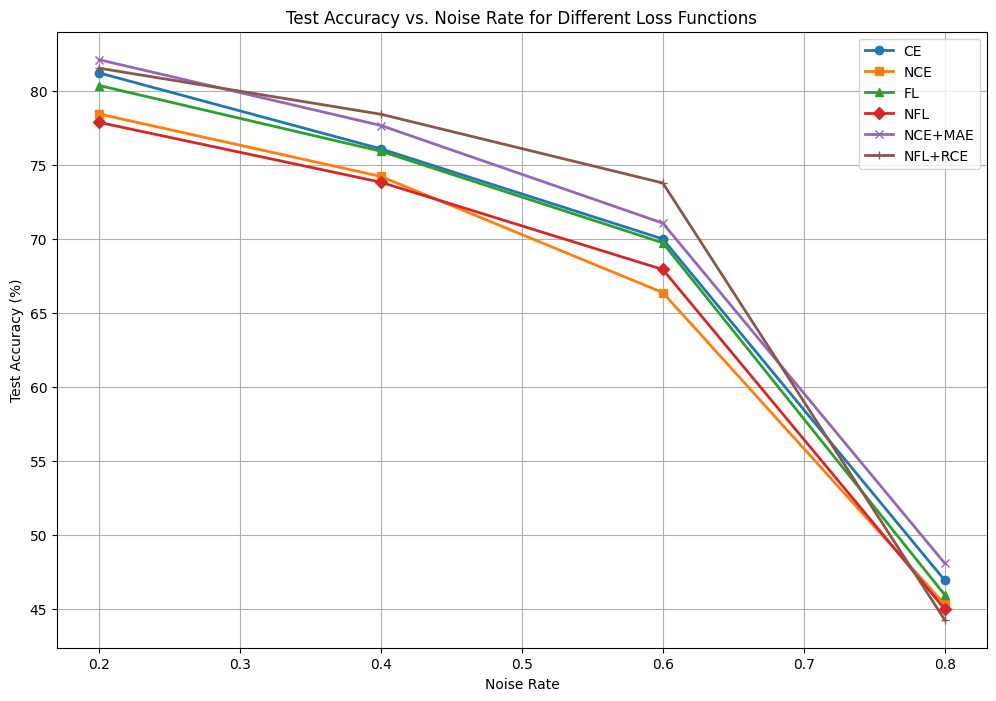

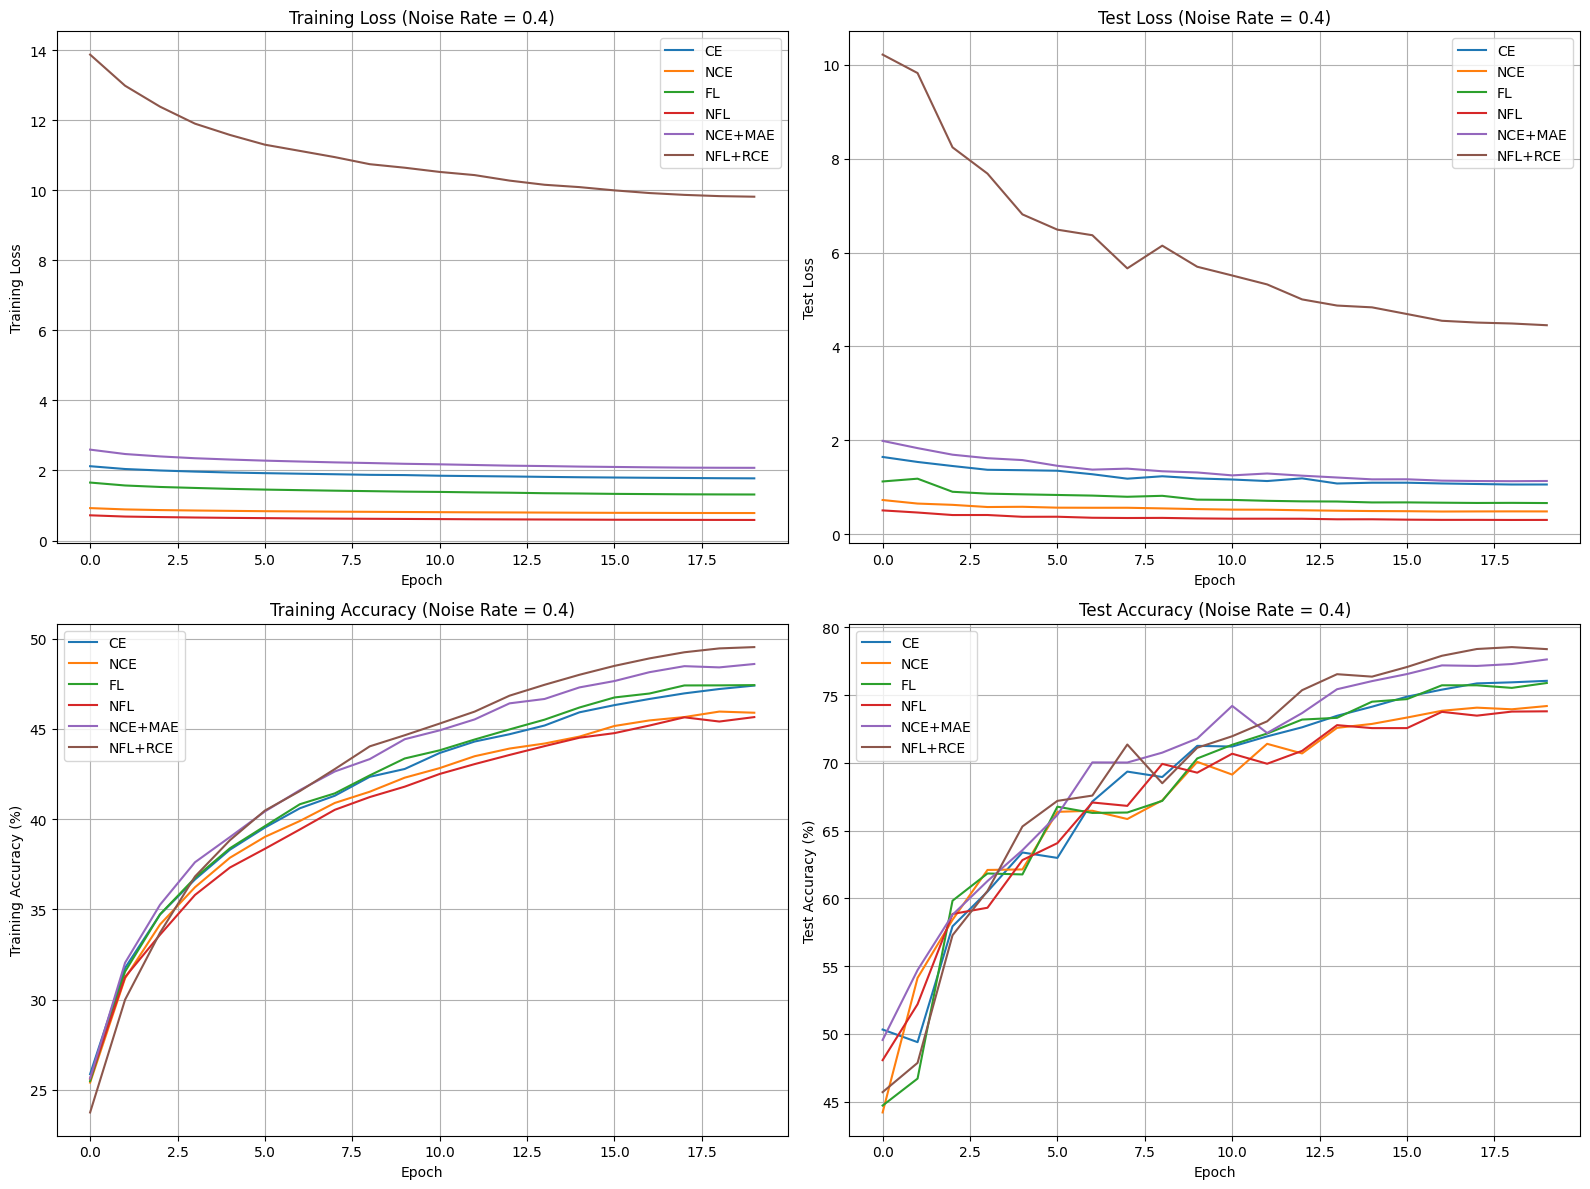

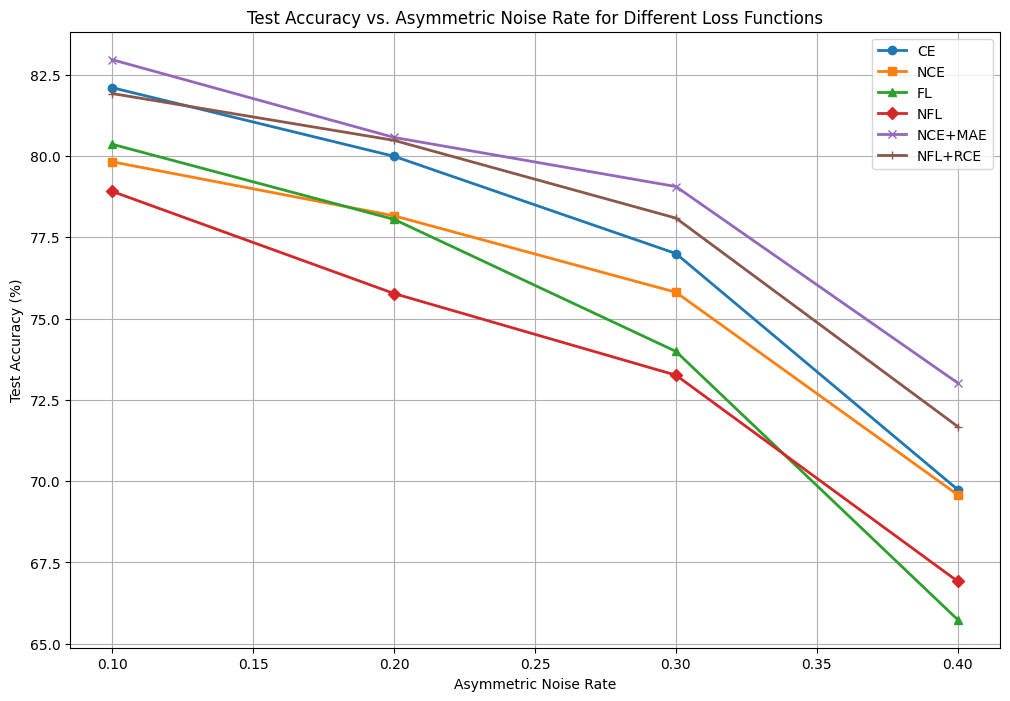

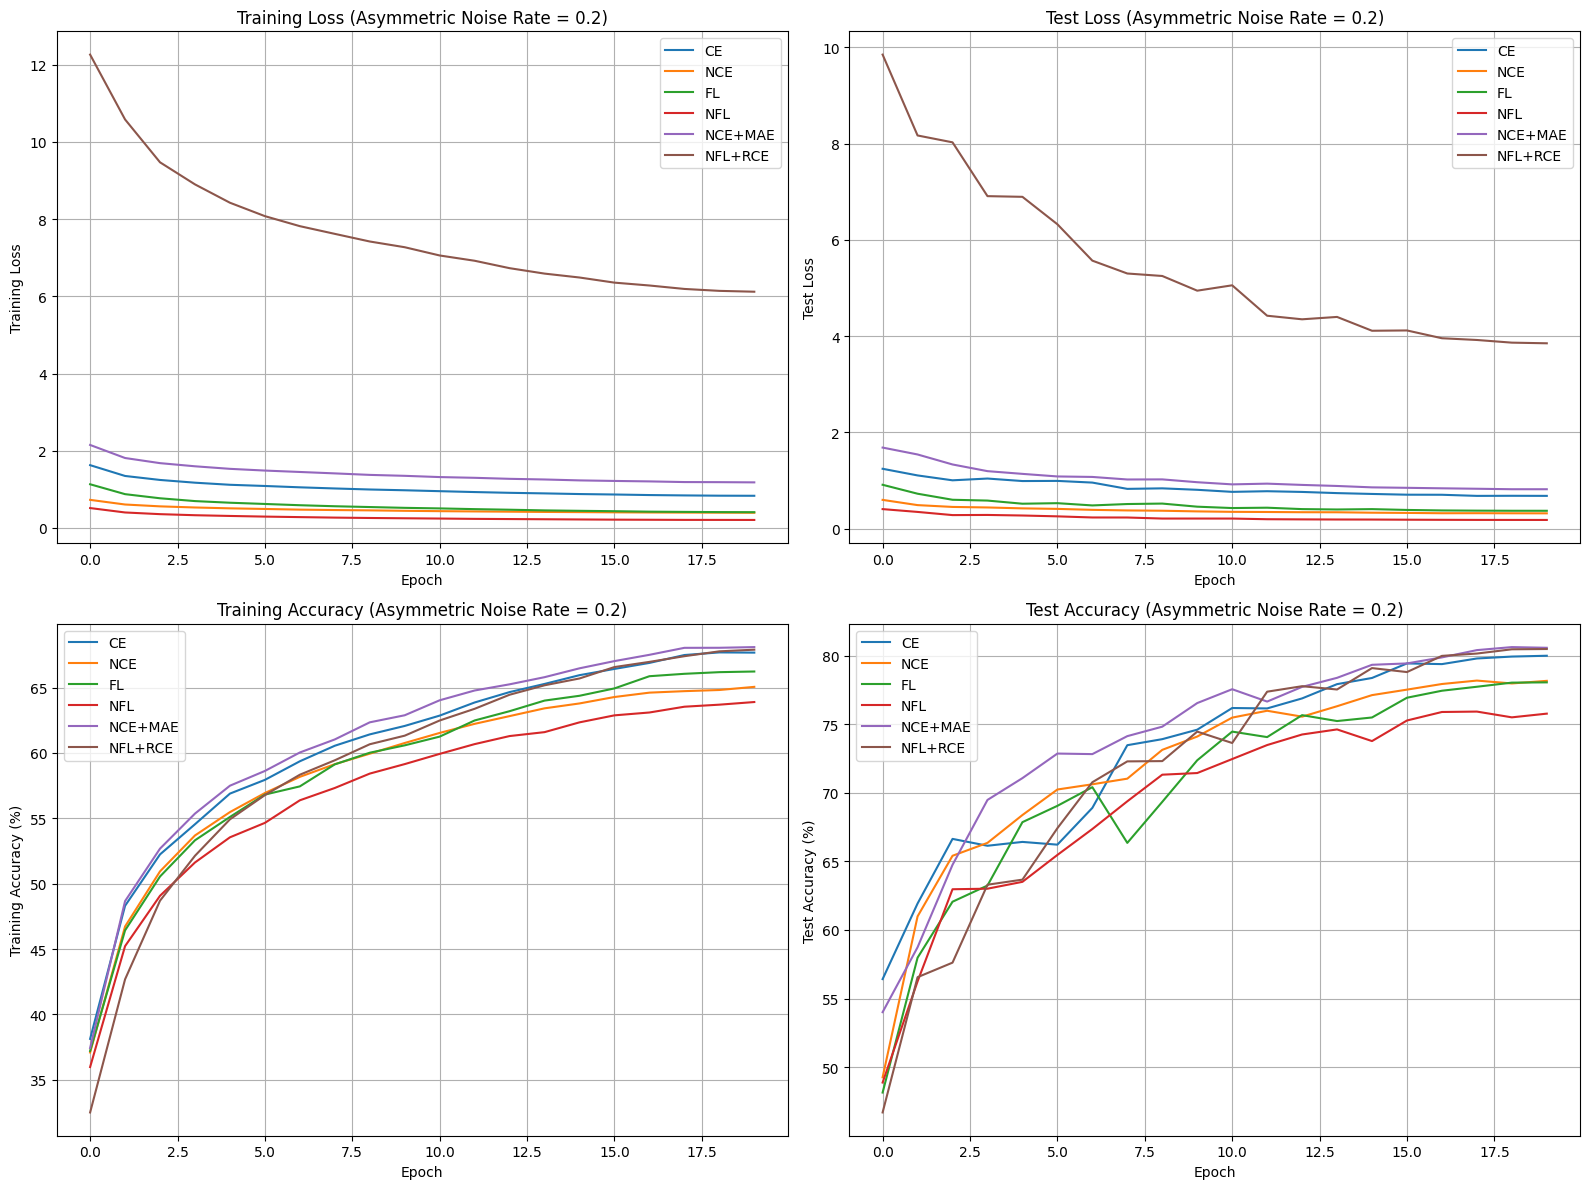

In [4]:
# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy
`
# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy

# Function to train and evaluate a model with a specific loss function
def run_experiment(noise_rate, noise_type, loss_type, epochs=20, batch_size=128):
    print(f"\nRunning experiment with {noise_type} noise rate {noise_rate}, loss: {loss_type}")

    # Create noisy dataset
    noisy_trainset = NoisyDataset(trainset, noise_rate=noise_rate, noise_type=noise_type)

    # Create data loaders
    train_loader = DataLoader(noisy_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = SimpleCNN().to(device)

    # Initialize loss function
    if loss_type == "CE":
        criterion = CrossEntropyLoss()
    elif loss_type == "NCE":
        criterion = NormalizedCrossEntropyLoss()
    elif loss_type == "FL":
        criterion = FocalLoss()
    elif loss_type == "NFL":
        criterion = NormalizedFocalLoss()
    elif loss_type == "MAE":
        criterion = MeanAbsoluteErrorLoss()
    elif loss_type == "RCE":
        criterion = ReverseCrossEntropyLoss()
    elif loss_type == "NCE+MAE":
        criterion = APLLoss(NormalizedCrossEntropyLoss(), MeanAbsoluteErrorLoss(), alpha=1.0, beta=1.0)
    elif loss_type == "NFL+RCE":
        criterion = APLLoss(NormalizedFocalLoss(), ReverseCrossEntropyLoss(), alpha=1.0, beta=1.0)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

    # Initialize optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Lists to store metrics
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'final_test_acc': test_accs[-1]
    }

def run_all_experiments():
    symmetric_noise_rates = [0.2, 0.4, 0.6, 0.8]
    asymmetric_noise_rates = [0.1, 0.2, 0.3, 0.4]  # Lower rates for asymmetric noise
    loss_types = ["CE", "NCE", "FL", "NFL", "NCE+MAE", "NFL+RCE"]

    symmetric_results = {}
    asymmetric_results = {}

    # Symmetric noise experiments
    for noise_rate in symmetric_noise_rates:
        symmetric_results[noise_rate] = {}
        for loss_type in loss_types:
            print(f"\n{'='*50}")
            print(f"Starting experiment with symmetric noise rate {noise_rate}, loss: {loss_type}")
            print(f"{'='*50}")

            start_time = time.time()
            result = run_experiment(noise_rate, "symmetric", loss_type)
            elapsed_time = time.time() - start_time

            symmetric_results[noise_rate][loss_type] = result
            print(f"Completed in {elapsed_time:.2f} seconds. Final test accuracy: {result['final_test_acc']:.2f}%")

    # Asymmetric noise experiments
    for noise_rate in asymmetric_noise_rates:
        asymmetric_results[noise_rate] = {}
        for loss_type in loss_types:
            print(f"\n{'='*50}")
            print(f"Starting experiment with asymmetric noise rate {noise_rate}, loss: {loss_type}")
            print(f"{'='*50}")

            start_time = time.time()
            result = run_experiment(noise_rate, "asymmetric", loss_type)
            elapsed_time = time.time() - start_time

            asymmetric_results[noise_rate][loss_type] = result
            print(f"Completed in {elapsed_time:.2f} seconds. Final test accuracy: {result['final_test_acc']:.2f}%")

    return symmetric_results, asymmetric_results

def plot_results(results):
    noise_rates = list(results.keys())
    loss_types = list(results[noise_rates[0]].keys())

    # Plot test accuracy for different noise rates and loss functions
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D', 'x', '+']

    for i, loss_type in enumerate(loss_types):
        accs = [results[nr][loss_type]['final_test_acc'] for nr in noise_rates]
        plt.plot(noise_rates, accs, marker=markers[i], linewidth=2, label=loss_type)

    plt.xlabel('Noise Rate')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy vs. Noise Rate for Different Loss Functions')
    plt.grid(True)
    plt.legend()
    plt.savefig('noise_rate_vs_accuracy.png')
    plt.show()

    # Plot training curves for a specific noise rate (e.g., 0.4)
    noise_rate = 0.4
    plt.figure(figsize=(16, 12))

    # Plot training loss
    plt.subplot(2, 2, 1)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['train_losses'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss (Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 2)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['test_losses'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title(f'Test Loss (Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 3)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['train_accs'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title(f'Training Accuracy (Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['test_accs'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Test Accuracy (Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_curves_noise_{noise_rate}.png')
    plt.show()


def plot_asymmetric_results(results):
    noise_rates = list(results.keys())
    loss_types = list(results[noise_rates[0]].keys())

    # Plot test accuracy for different noise rates and loss functions
    plt.figure(figsize=(12, 8))
    markers = ['o', 's', '^', 'D', 'x', '+']

    for i, loss_type in enumerate(loss_types):
        accs = [results[nr][loss_type]['final_test_acc'] for nr in noise_rates]
        plt.plot(noise_rates, accs, marker=markers[i], linewidth=2, label=loss_type)

    plt.xlabel('Asymmetric Noise Rate')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy vs. Asymmetric Noise Rate for Different Loss Functions')
    plt.grid(True)
    plt.legend()
    plt.savefig('asymmetric_noise_rate_vs_accuracy.png')
    plt.show()

    # Plot training curves for a specific noise rate (e.g., 0.2)
    noise_rate = 0.2
    plt.figure(figsize=(16, 12))

    # Plot training loss
    plt.subplot(2, 2, 1)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['train_losses'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss (Asymmetric Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 2)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['test_losses'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title(f'Test Loss (Asymmetric Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 3)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['train_accs'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title(f'Training Accuracy (Asymmetric Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for loss_type in loss_types:
        plt.plot(results[noise_rate][loss_type]['test_accs'], label=loss_type)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Test Accuracy (Asymmetric Noise Rate = {noise_rate})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'asymmetric_training_curves_noise_{noise_rate}.png')
    plt.show()




def main():
    symmetric_results, asymmetric_results = run_all_experiments()
    plot_results(symmetric_results)  # Your existing function for symmetric results
    plot_asymmetric_results(asymmetric_results)  # New function for asymmetric results

if __name__ == "__main__":
    main()


